# Population decoding
Attempt at decoding behavioral data from population level neural activity.

In [1]:
import pandas as pd
from pathlib import Path
import sys
import statsmodels.api as sm
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
from fcutils.plot.figure import clean_axes
from sklearn.model_selection import KFold
from myterial import teal_dark, teal, indigo_dark, blue_darker, pink, salmon_dark

colors = dict(
    s=teal_dark,
    curv_10cm=teal,
    curv_15cm=teal,
    curv_20cm=teal,
    curv_30cm=teal,
    v=salmon_dark, 
    dv_250ms=pink,
    dv_500ms=pink,
    dv_1000ms=pink,
    omega=blue_darker,
    domega_250ms=indigo_dark,
    domega_500ms=indigo_dark,
    domega_1000ms=indigo_dark,
)


sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")


glm_cache = Path(
    r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\GLM\data"
)
population_cache = Path(
    r"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\population\data"
)

## Load data

In [2]:
df = pd.read_parquet(population_cache / "FC_220414_BAA1101192_hairpin.parquet")
df = df.drop(columns=["curv_35cm", "curv_40cm", "curv_45cm", "curv_50cm", "curv_55cm", "curv_60cm"], inplace=False)

# remove rows with nans
print(df.shape)
df = df.dropna(axis=0)
print(df.shape)
df.reset_index(inplace=True, drop=True)


units = [c for c in df.columns[24:] if "shuffle" not in c]

# activity.head()

(26414, 1937)
(23518, 1937)


## Fit OLS to predict stuff

Using 5x kfold cross validation, fit OLS linear prediction to various behavioral variables from neural activity.
Fit models for real neural data and for each shuffles of real data.
Then look for which variables we can do better than the shuffles.

In [3]:
from scipy.stats import pearsonr
RESULTS = dict()
MODELS = dict()

In [4]:
variables = ["s", "v", "dv_500ms", "omega",  "domega_500ms", "curv_15cm"]
behav_vars = dict(
    s = ["v", "dv_500ms", "omega",  "domega_500ms"],
    curv_15cm = ["v", "dv_500ms", "omega",  "domega_500ms"],
    v = ["s", "curv_15cm", "omega",  "domega_500ms"],
    dv_500ms = ["s", "curv_15cm", "omega",  "domega_500ms"],
    omega = ["s", "curv_15cm", "v",  "dv_500ms"],
    domega_500ms = ["s", "curv_15cm", "v",  "dv_500ms"],
)

X = add_constant(df[units])
X_shuffle = {
    i: add_constant(df[[f"{unit}_shuffle_{i}" for unit in units]]) for i in range(100)
}

for var in variables:   
    print(f"Doing {var}") 
    Y = df[var]

    # split into 5x kfold
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)


    # store Pearson's r of each model
    performance = {
        i: [] for i in range(100)
    }
    performance["real"] = []
    performance["behav"] = []


    for train_index, test_index in kf.split(df):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # fit OLS & getc correlation on test
        model = sm.OLS(Y_train, X_train).fit_regularized()
        performance["real"].append(pearsonr(Y_test, model.predict(X_test))[0])


        # fit for each shuffle
        for i in range(100):
            X_train_shuffle = X_shuffle[i].iloc[train_index]
            X_test_shuffle = X_shuffle[i].iloc[test_index]

            # fit shuffled and get correlation
            model_shuffle = sm.OLS(Y_train, X_train_shuffle).fit_regularized()
            performance[i].append(pearsonr(Y_test, model_shuffle.predict(X_test_shuffle))[0])

        # fit model based on behavioral variables only
        X_train_bvars = add_constant(df[behav_vars[var]].iloc[train_index])
        X_test_bvars = add_constant(df[behav_vars[var]].iloc[test_index])

        model_bvars = sm.OLS(Y_train, X_train_bvars).fit_regularized()
        performance["behav"].append(pearsonr(Y_test, model_bvars.predict(X_test_bvars))[0])

    RESULTS[var] = performance
    MODELS[var] = dict(real=model, shufle=model_shuffle, behav=model_bvars)

Doing s
Doing v
Doing dv_500ms


<Figure size 1440x1296 with 12 Axes>

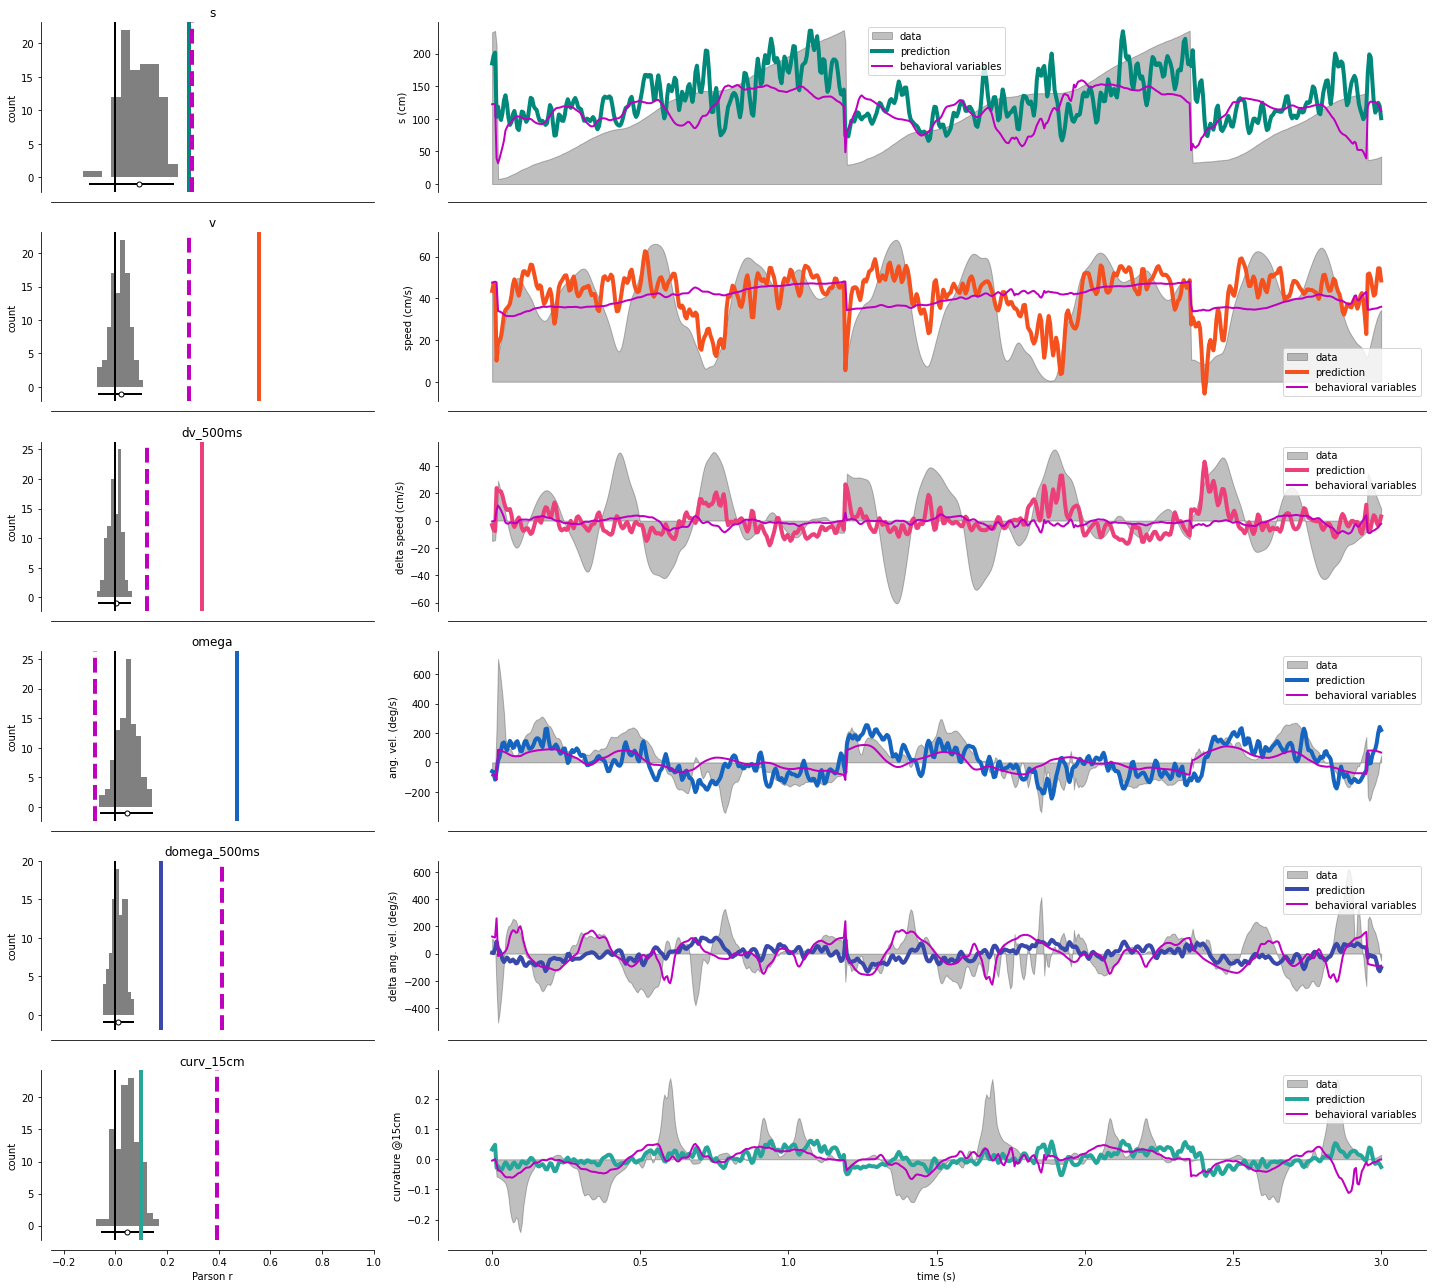

In [ ]:
# plot histogram of average MSE for each shuffle
import numpy as np

f, axes = plt.subplots(ncols=2, nrows=len(variables), figsize=(20, 18), gridspec_kw={"width_ratios": [.33, 1]}, sharex=False)

for i, var in enumerate(variables):
    # plot pearsonr distributions
    avg_shuff_pearsonr = [np.mean(RESULTS[var][i]) for i in range(100)]

    low, high = np.percentile(avg_shuff_pearsonr, [.5, 99.5])
    axes[i, 0].plot([low, high], [-1, -1], color="k", linewidth=2)
    axes[i, 0].scatter([np.median(avg_shuff_pearsonr)], [-1], color="white",fc="white", zorder=100, ec="k", linewidth=1, s=25)

    axes[i, 0].hist(avg_shuff_pearsonr, color=[.5, .5, .5])
    axes[i, 0].axvline(np.mean(RESULTS[var]["real"]), color=colors[var], lw=4)
    axes[i, 0].axvline(np.mean(RESULTS[var]["behav"]), color="m", lw=4, ls="--")
    
    axes[i, 0].set(title=var, xlim=[-.25, 1])
    axes[i, 0].axvline(0, lw=2, color="k", zorder=100)

    # plot predictions of real and shuffled models
    T = np.linspace(0, int(600 * 5 / 1000), 600)
    axes[i, 1].fill_between(T, df[var][2000:2600], 0, color="k", alpha=.25, label="data")
    axes[i, 1].plot(T, MODELS[var]["real"].predict(X[2000:2600]), color=colors[var], lw=4, label="prediction")

    Xbvars = add_constant(df[behav_vars[var]])
    axes[i, 1].plot(T, MODELS[var]["behav"].predict(Xbvars[2000:2600]), color="m",label="behavioral variables", lw=2)
    axes[i, 1].legend()

axes[0, 0].set(ylabel="count", xticks=[])
axes[1, 0].set(ylabel="count", xticks=[])
axes[2, 0].set(ylabel="count", xticks=[])
axes[3, 0].set(ylabel="count", xticks=[])
axes[4, 0].set(ylabel="count", xticks=[])
axes[5, 0].set(ylabel="count", xlabel="Parson r")

axes[0, 1].set(ylabel="s (cm)", xticks=[])
axes[1, 1].set(ylabel="speed (cm/s)", xticks=[])
axes[2, 1].set(ylabel="delta speed (cm/s)", xticks=[])
axes[3, 1].set(ylabel="ang. vel. (deg/s)", xticks=[])
axes[4, 1].set(ylabel="delta ang. vel. (deg/s)", xticks=[])
axes[5, 1].set(ylabel="curvature @15cm", xlabel="time (s)")

clean_axes(f)
f.tight_layout()


